In [20]:
import time
from glob import glob
from tqdm import tqdm
import pandas as pd
from utils import get_hour_crawl_df_lst
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from IPython.display import clear_output
sns.set_palette("Set1", 7)
sns.color_palette("Set1", 7)


[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392)]

In [21]:
last_week = sorted(glob('/mnt/sda/tnecniv/tnecniv-2023/*-*'))[-2]
last_week_hour_csv = sorted(glob(last_week+'/*-*.csv'))
game_ratings_df = pd.read_csv('./result_collection/game_ratings_simplified_sorted.csv')
#top_10_mgames = game_ratings_df[game_ratings_df['ratings'] == 'T']['game_name'][:10].tolist()
top_10_mgames = ['Grand Theft Auto V', 'Counter-Strike', 'Call of Duty: Warzone', 'Escape from Tarkov', 'Dead by Daylight', 'Slots', 'ELDEN RING', 'Hunt: Showdown', 'DayZ', 'Rust', 'Diablo III', 'Lost Ark', "Tom Clancy's Rainbow Six Siege", 'Red Dead Redemption 2', 'Resident Evil 4', 'Phasmophobia', 'Diablo II: Resurrected', 'HITMAN World of Assassination', 'Last Epoch'][:10]

ccl_lst = ['DrugsIntoxication', 'Gambling', 'MatureGame', 'ProfanityVulgarity', 'SexualThemes', 'ViolentGraphic']
ccl_dict = {c[0]:c for c in ccl_lst}
first_day = last_week_hour_csv[0].split('/')[-1][:6]
last_day = last_week_hour_csv[-1].split('/')[-1][:6]
first_day, last_day

('240324', '240330')

In [22]:
for csv in tqdm(last_week_hour_csv):
    df_lst = get_hour_crawl_df_lst(csv)
    for df in df_lst:
        break
    break

  0%|          | 0/168 [00:01<?, ?it/s]


In [23]:
df[3:4]

,id,user_id,user_login,game_id,game_name,viewer_count,started_at,language,is_mature,crawl_started_at,crawl_ended_at,content_classification_labels
3,42438335561,181077473,gaules,32399,Counter-Strike,62470,24/03/23-19:20:39,pt,True,24/03/24-00:00:00,24/03/24-00:04:13,M


In [24]:
error_df_lst = []
for csv in tqdm(last_week_hour_csv):
    df_lst = get_hour_crawl_df_lst(csv)
    for df in df_lst:
        mislabeled = df[['game_name', 'content_classification_labels']][(df['game_name'].isin(top_10_mgames)) & (df['content_classification_labels']=='')].groupby('game_name').count().to_dict()['content_classification_labels']
        total_count = df[['game_name', 'content_classification_labels']][(df['game_name'].isin(top_10_mgames))].groupby('game_name').count().to_dict()['content_classification_labels']
        error_rate_mgames = {}
        for k in total_count.keys():
            try:
                error_rate_mgames[k] = mislabeled[k] / total_count[k]
            except:
                error_rate_mgames[k] = 0
        error_df_lst.append(pd.Series(error_rate_mgames).to_frame().reindex(top_10_mgames))

100%|██████████| 168/168 [03:49<00:00,  1.36s/it]


In [25]:
mislabeled = df[['game_name', 'content_classification_labels']][(df['game_name'].isin(top_10_mgames)) & (df['content_classification_labels']=='')].groupby('game_name').count().to_dict()['content_classification_labels']
total_count = df[['game_name', 'content_classification_labels']][(df['game_name'].isin(top_10_mgames))].groupby('game_name').count().to_dict()['content_classification_labels']
error_rate_mgames = {}
for k in total_count.keys():
    try:
        error_rate_mgames[k] = mislabeled[k] / total_count[k]
    except:
        error_rate_mgames[k] = 0

In [26]:
df = pd.Series(error_rate_mgames).to_frame().reindex(top_10_mgames)
df[1] = 1-df[0]
df

,0,1
Grand Theft Auto V,0.006024,0.993976
Counter-Strike,0.006691,0.993309
Call of Duty: Warzone,0.011281,0.988719
Escape from Tarkov,0.006935,0.993065
Dead by Daylight,0.007646,0.992354
Slots,0.021053,0.978947
ELDEN RING,0.005025,0.994975
Hunt: Showdown,0.000000,1.000000
DayZ,0.010444,0.989556
Rust,0.004831,0.995169


In [37]:
error_df_processed = []
for error_df in error_df_lst:
    error_df[1] = 1-error_df[0]
    error_df_processed.append(error_df[[1]])

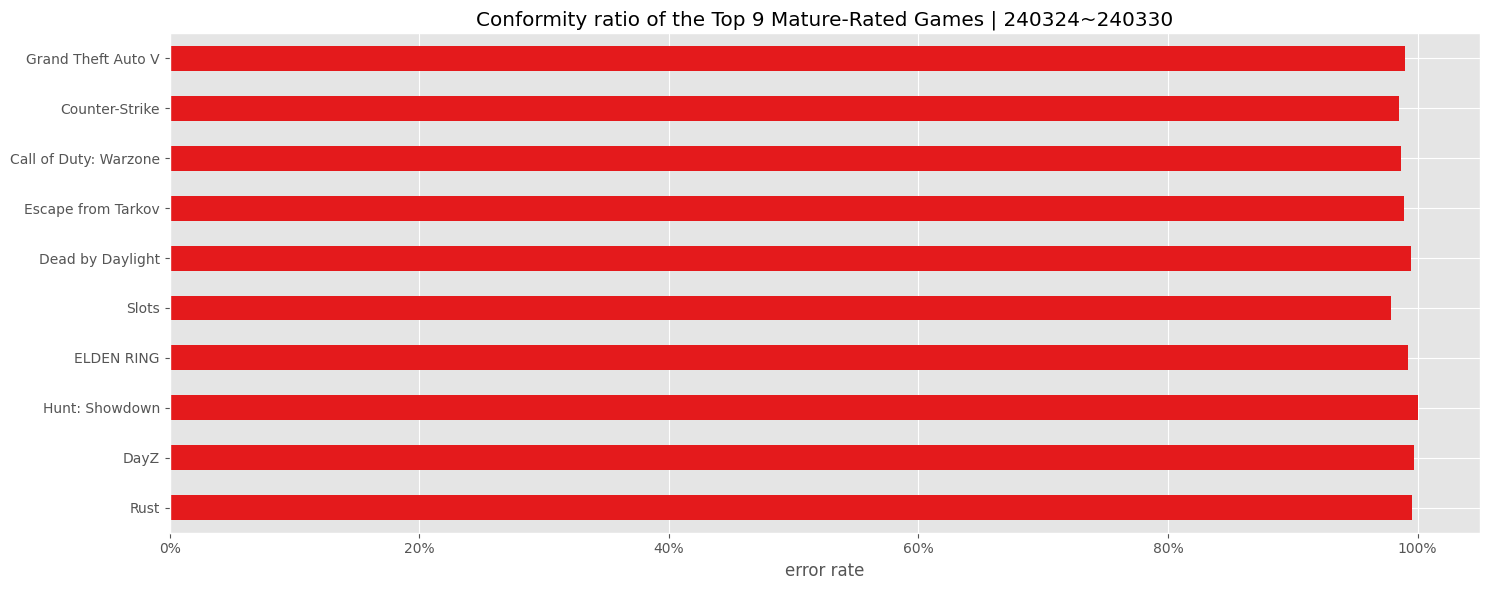

  0%|          | 0/1008 [00:00<?, ?it/s]


In [42]:
for error_df in tqdm(error_df_processed):
    clear_output(wait=True)    
    fig, ax = plt.subplots(figsize=(15, 6))
    ax = error_df.plot(kind='barh', ax=ax, stacked=True, legend=False)
    ax.invert_yaxis()
    # for patch in ax.patches[:6]:
    #     patch.set_alpha(0)
    ax.set_title(f'Conformity ratio of the Top 9 Mature-Rated Games | {first_day}~{last_day}')
    ax.set_xlabel('error rate')
    ax.set_xticks(ax.get_xticks()[:-1], [str(round(x, 1))+'%' for x in (ax.get_xticks()[:-1]*100).astype(int)])
    fig.tight_layout()
    plt.show()
    time.sleep(.05)
    break


In [29]:
ccl_stats = {f'{l[0]}_{attr}':[] for l in ccl_lst for attr in ['abbr', 'full']}
ccl_abbr_lst = [c[0] for c in ccl_lst]

for csv in tqdm(last_week_hour_csv):
    df_lst = get_hour_crawl_df_lst(csv)
    for df in df_lst:
        stream_count_abbr = df[df['content_classification_labels'] != ""].shape[0]
        stream_count_full = df.shape[0]
        for ccl in ccl_abbr_lst:
            for attr in ['abbr', 'full']:
                if(attr == 'abbr'):
                    ccl_stats[f'{ccl}_{attr}'].append(df[df['content_classification_labels'].str.contains(ccl)].shape[0] / stream_count_abbr)
                else:
                    ccl_stats[f'{ccl}_{attr}'].append(df[df['content_classification_labels'].str.contains(ccl)].shape[0] / stream_count_full)


100%|██████████| 168/168 [06:35<00:00,  2.35s/it]


In [30]:
[f"{c}_{attr}" for attr in ['abbr', 'full'] for c in ccl_lst]

['DrugsIntoxication_abbr',
 'Gambling_abbr',
 'MatureGame_abbr',
 'ProfanityVulgarity_abbr',
 'SexualThemes_abbr',
 'ViolentGraphic_abbr',
 'DrugsIntoxication_full',
 'Gambling_full',
 'MatureGame_full',
 'ProfanityVulgarity_full',
 'SexualThemes_full',
 'ViolentGraphic_full']

In [31]:
_column_idx = [f"{c[0]}_{attr}" for attr in ['abbr', 'full'] for c in ccl_lst]
df = pd.DataFrame(ccl_stats)[_column_idx]
df.rename(columns={f'{c[0]}_{attr}': f'{c}_{attr}' for c in ccl_lst for attr in ['abbr', 'full']}, inplace=True)
df

,DrugsIntoxication_abbr,Gambling_abbr,MatureGame_abbr,ProfanityVulgarity_abbr,SexualThemes_abbr,ViolentGraphic_abbr,DrugsIntoxication_full,Gambling_full,MatureGame_full,ProfanityVulgarity_full,SexualThemes_full,ViolentGraphic_full
0,0.096410,0.035514,0.781242,0.250539,0.088798,0.129524,0.033883,0.012481,0.274564,0.088051,0.031208,0.045521
1,0.097400,0.035832,0.779439,0.251940,0.089543,0.129732,0.034449,0.012673,0.275674,0.089107,0.031670,0.045884
2,0.097184,0.035265,0.779213,0.252782,0.089326,0.131484,0.034424,0.012491,0.276012,0.089540,0.031641,0.046574
3,0.098423,0.035517,0.778514,0.254070,0.088839,0.131238,0.035144,0.012682,0.277987,0.090722,0.031722,0.046862
4,0.098990,0.035262,0.779532,0.254932,0.088999,0.131355,0.035592,0.012678,0.280279,0.091661,0.032000,0.047229
...,...,...,...,...,...,...,...,...,...,...,...,...
1003,0.096456,0.034154,0.779614,0.248870,0.089889,0.131423,0.032621,0.011551,0.263662,0.084167,0.030400,0.044447
1004,0.097470,0.033684,0.779867,0.249407,0.089972,0.131705,0.033201,0.011474,0.265648,0.084956,0.030647,0.044863
1005,0.097359,0.032813,0.780009,0.248993,0.089332,0.130984,0.033384,0.011252,0.267464,0.085379,0.030632,0.044914
1006,0.096615,0.032808,0.779815,0.250200,0.088872,0.131499,0.033359,0.011328,0.269252,0.086388,0.030686,0.045404


In [32]:
df.filter(like='abbr', axis=1)

,DrugsIntoxication_abbr,Gambling_abbr,MatureGame_abbr,ProfanityVulgarity_abbr,SexualThemes_abbr,ViolentGraphic_abbr
0,0.096410,0.035514,0.781242,0.250539,0.088798,0.129524
1,0.097400,0.035832,0.779439,0.251940,0.089543,0.129732
2,0.097184,0.035265,0.779213,0.252782,0.089326,0.131484
3,0.098423,0.035517,0.778514,0.254070,0.088839,0.131238
4,0.098990,0.035262,0.779532,0.254932,0.088999,0.131355
...,...,...,...,...,...,...
1003,0.096456,0.034154,0.779614,0.248870,0.089889,0.131423
1004,0.097470,0.033684,0.779867,0.249407,0.089972,0.131705
1005,0.097359,0.032813,0.780009,0.248993,0.089332,0.130984
1006,0.096615,0.032808,0.779815,0.250200,0.088872,0.131499


In [33]:
pd.DataFrame(ccl_stats)[_column_idx].rename({f'{c[0]}_{attr}': c for c in ccl_lst for attr in ['abbr', 'full']}, axis=1)

,DrugsIntoxication,Gambling,MatureGame,ProfanityVulgarity,SexualThemes,ViolentGraphic,DrugsIntoxication,Gambling,MatureGame,ProfanityVulgarity,SexualThemes,ViolentGraphic
0,0.096410,0.035514,0.781242,0.250539,0.088798,0.129524,0.033883,0.012481,0.274564,0.088051,0.031208,0.045521
1,0.097400,0.035832,0.779439,0.251940,0.089543,0.129732,0.034449,0.012673,0.275674,0.089107,0.031670,0.045884
2,0.097184,0.035265,0.779213,0.252782,0.089326,0.131484,0.034424,0.012491,0.276012,0.089540,0.031641,0.046574
3,0.098423,0.035517,0.778514,0.254070,0.088839,0.131238,0.035144,0.012682,0.277987,0.090722,0.031722,0.046862
4,0.098990,0.035262,0.779532,0.254932,0.088999,0.131355,0.035592,0.012678,0.280279,0.091661,0.032000,0.047229
...,...,...,...,...,...,...,...,...,...,...,...,...
1003,0.096456,0.034154,0.779614,0.248870,0.089889,0.131423,0.032621,0.011551,0.263662,0.084167,0.030400,0.044447
1004,0.097470,0.033684,0.779867,0.249407,0.089972,0.131705,0.033201,0.011474,0.265648,0.084956,0.030647,0.044863
1005,0.097359,0.032813,0.780009,0.248993,0.089332,0.130984,0.033384,0.011252,0.267464,0.085379,0.030632,0.044914
1006,0.096615,0.032808,0.779815,0.250200,0.088872,0.131499,0.033359,0.011328,0.269252,0.086388,0.030686,0.045404


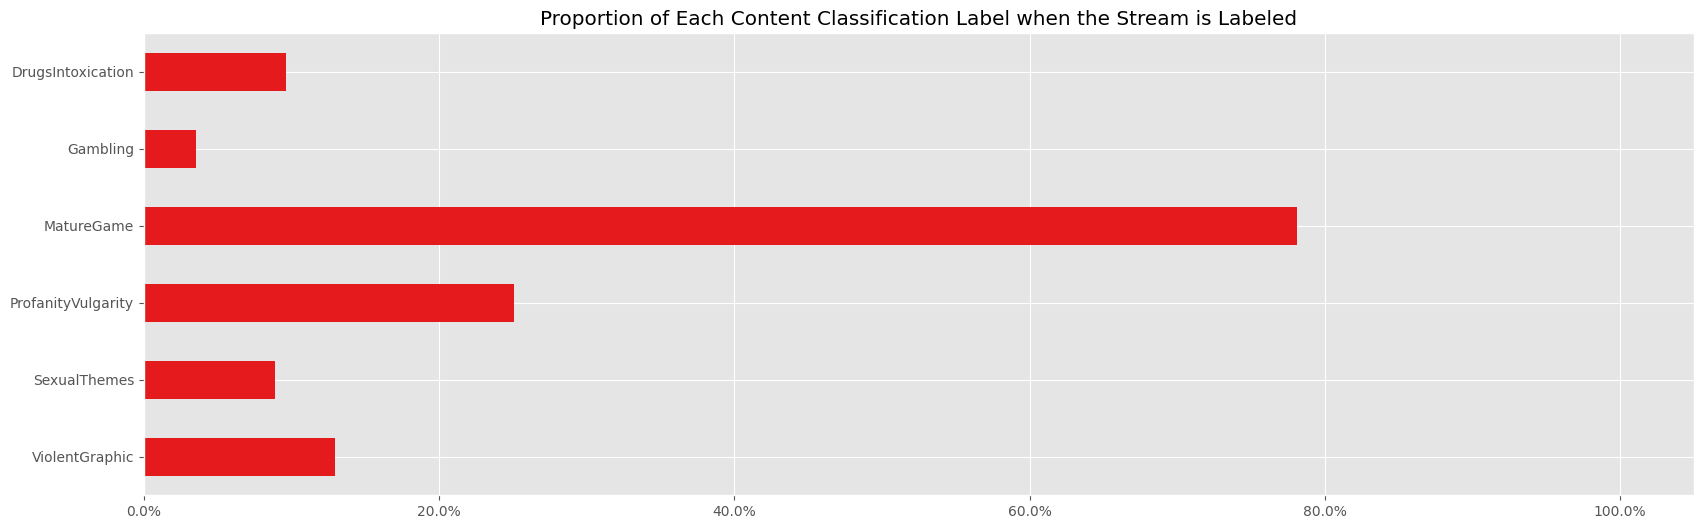

In [34]:
ccl_df = pd.DataFrame(ccl_stats)[_column_idx].filter(like='abbr', axis=1).rename({f'{c[0]}_{attr}': c for c in ccl_lst for attr in ['abbr', 'full']}, axis=1)
for i, ccl_row in ccl_df.iterrows():
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(20, 6))

    df = ccl_row.to_frame()
    df[i+1] = 1 - df[i]
    df.columns = ['labeled', 'not-labeled']
    ax = df.plot(kind='barh', ax=ax, stacked=True, legend=False)
    ax.invert_yaxis()
    for patch in ax.patches[6:]:
        patch.set_alpha(0)
    ax.set_xticks(ax.get_xticks()[:-1], [str(round(x, 0))+'%' for x in ax.get_xticks()[:-1]*100])
    ax.set_title('Proportion of Each Content Classification Label when the Stream is Labeled')
    plt.show()
    break
